In [138]:
#ZetaPotentialAndSurfVelocityCalc
#CKH Sept11 2016 - work with csv files exported from an axisymmetric Maxwell sim
#Starting from a stl file with units of mm, where each mm corresponds to 1 micron
#(because openSCAD barfs if you try to use microns)
#Export a contour from an insulating-pore Maxwell sim. Bring in x,y,z coords, tangential E-field and voltage in a comma delimited .csv or .txt file 
#This program will calculate the local zeta potential and surface velocity using the method of Wu and Li (2008)
#Wu, Zhemin, and Dongqing Li. "Mixing and flow regulating by induced-charge electrokinetic flow in a microchannel with a pair of conducting triangle hurdles." Microfluidics and nanofluidics 5.1 (2008): 65-76.

In [139]:
#Something about units here
#Maxwell will export units in the column labels. Check below for a list of the column labels.
epsilon =80.0*8.854e-12 #dielectric constant of water in F/m
eta=8.9e-4 #dynamic viscosity of water in Pa*s

#Currently ignores surface velocity on the polymer, because its time average is 0 when 
#driven by a pure AC electric field. 
#But it would be needed if we want to flip the sign of the voltage and show the flow pattern in each half cycle.
#zetaPolymer=-0.02#zeta potential of the bare polymer membrane in volts
#It will depend on what the surrounding solution is
#I used -20 mV for polycarbonate at low concentration (pC near 0) and medium pH around 7
#From fig 2b in Electrophoresis (2004) 25, 203–213
#http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.559.3862&rep=rep1&type=pdf

In [140]:
#imports
import numpy as np

In [141]:
#Path names for input and output files
inputfile='./MaxwellResults/1000nmPore.csv'
outputSuffix='.txt'#going to generate geometry data labels from the file

In [142]:
#Reading in the Maxwell file
simdata= np.genfromtxt(inputfile, dtype=float, delimiter=',',names=True)#Wonderful, can call columns by names
#Report the names it found, this will help with troubleshooting
simdata.dtype.names
#I see a label Voltage_V, this means I can get the voltages along the contour by stitchdata['Voltage_V']


('Distance_mm',
 'Voltage_V',
 'XCoord_',
 'YCoord_',
 'ZCoord_',
 'TangUnitVecX_',
 'TangUnitVecY_',
 'TangUnitVecZ_',
 'E_Tang_')

In [143]:
#Convert everything that's not meters and V/m, to meters and V/m
#And make it so the original mm-based OpenSCAD drawings are
#actually microns
Distance=simdata['Distance_mm']/1000/1000 #Put distance along contour in meters, make original units microns
voltage=simdata['Voltage_V']#Voltage does not change
#MagE_V_per_meter is not being used
x=simdata['XCoord_']/1000 #It's still in meters, but makes the original units microns instead of mm
y=simdata['YCoord_']/1000 #same
z=simdata['ZCoord_']/1000 #same
#Tangential unit vectors do not change, these are needed to write out velocity profiles.
tangx=simdata['TangUnitVecX_']
tangy=simdata['TangUnitVecY_']#these are 0 if we draw the contour in the xy plane
tangz=simdata['TangUnitVecZ_']
E_Tang=simdata['E_Tang_']*1000 #Still in V/m but adjusted so the original units were microns instead of mm


In [144]:
#Fix for tacky matplotlib bug where scatterplot won't scale down to tiny data values
def set_axlims(x,y, marginfactor):#Manual limits for some xy data if you dont care about axis equal
    minx = x.min()
    maxx = x.max()   #for instance voltage vs distance or other plots without same units for x & y
    miny = y.min()
    maxy = y.max()
    xdatarange = maxx-minx
    ydatarange = maxy-miny        
    xborder = abs(xdatarange*marginfactor)
    yborder = abs(ydatarange*marginfactor)
    maxxlim = maxx+xborder
    minxlim = minx-xborder
    maxylim = maxy+yborder
    minylim = miny-yborder
    return minxlim,maxxlim,minylim,maxylim

In [145]:
#Axis-equal version of fix for matplotlib bug where scatterplot won't scale down to tiny data values
def set_eq_axlims(x,y, marginfactor):
    minx = x.min()
    maxx = x.max()
    miny = y.min()
    maxy = y.max()
    xdatarange = maxx-minx
    ydatarange = maxy-miny  
    centerx=(maxx+minx)/2
    centery=(maxy+miny)/2
    if xdatarange>ydatarange: #ydatarange is going to define it
        ydatarange=xdatarange
    else:
        xdatarange=ydatarange
    xborder = abs(xdatarange*marginfactor)
    yborder = xborder
    maxxlim = centerx+xdatarange/2+xborder
    minxlim = centerx-xdatarange/2-xborder
    maxylim = centery+ydatarange/2+yborder
    minylim = centery-ydatarange/2-yborder
    return minxlim,maxxlim,minylim,maxylim

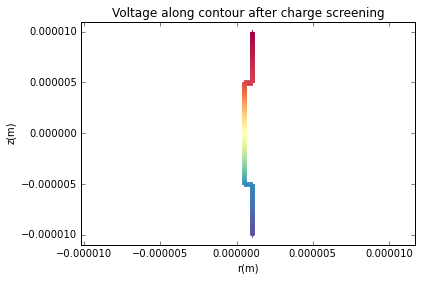

In [146]:
#Plotting code
#Get some colors corresponding to voltages along the line, ranging from 0 to 1

v=(voltage-np.min(voltage))/(np.max(voltage)-np.min(voltage))
#maybe it will autoscale without doing this, I'm getting mixed results
#Let's use r and z, r is sqrt(x**2+y**2) since I took a slice right through the z-axis.
#%matplotlib inline

r=np.sqrt(x**2+y**2)
%matplotlib inline
from matplotlib import pyplot as plt

cMap=plt.cm.get_cmap('Spectral_r')#if i don't change this it tends to default to grayscale
plt.set_cmap(cMap)
plt.scatter(r,z,c=v,marker='+')#so much struggle to get the right kind of marker that would show the color!
plt.title('Voltage along contour after charge screening') #Maxwell does better plots with color bars for scale
#The purpose of this plot is to check on what I imported, and see whether it makes any sense
#It didnt work w/ tiny data values because of a bug in matplotlib
#http://stackoverflow.com/questions/37634370/matplotlib-scatterplot-axis-autoscale-fails-for-small-data-values
ax=plt.gca()
lims=set_eq_axlims(r,z,.05)  #my function to repair this bug
ax.set_xlim(lims[0],lims[1])
ax.set_ylim(lims[2],lims[3])
plt.xlabel('r(m)')
plt.ylabel('z(m)')
#looks like the electric field is downward along center of pore (-z direction), because E goes from pos voltage (red) 
#to negative (blue)


(-1.1000000000000001e-05, 1.1000000000000001e-05)

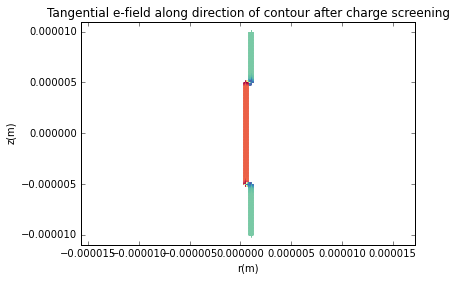

In [147]:
#Now look at the tangential value of the E-field along the direction of the contour
etang=simdata['E_Tang_']
e=(etang-np.min(etang))/(np.max(etang)-np.min(etang))
plt.scatter(r,z,c=e,marker='+')
plt.axis('equal')
plt.title('Tangential e-field along direction of contour after charge screening') #Maxwell does better plots with color bars for scale
#Like before, the purpose of this plot is to check on what I imported, does it make sense?
plt.xlabel('r(m)')
plt.ylabel('z(m)')
ax=plt.gca()
lims=set_eq_axlims(r,z,.05)  #my function to repair this bug
ax.set_xlim(lims[0],lims[1])
ax.set_ylim(lims[2],lims[3])

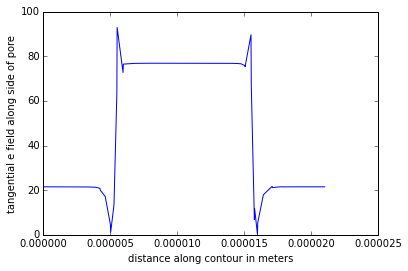

In [148]:
#I have to keep in mind the tangential E-field (etang) is defined along contour direcion. 
#The actual E direction flips sign from top to bottom
#Check out relative magnitude of etang

plt.plot(Distance, etang)
plt.xlabel('distance along contour in meters')
plt.ylabel('tangential e field along side of pore')
#looks like in the pore, at distances 70-110, etangential is negative. does it make sense?

(-1.1000000000000001e-05, 1.1000000000000001e-05)

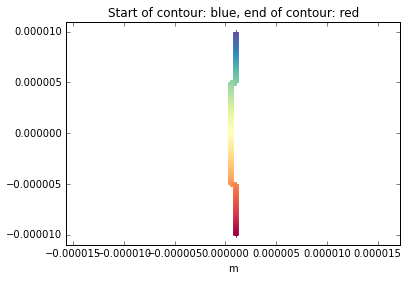

In [149]:
#OK... which is the start and end of the contour? In my plot, using the 'Spectral_r' colormap 
#the contour starts at blue and ends at red
#This will help explain the sign of etangential
normdist=(Distance-np.min(Distance))/(np.max(Distance)-np.min(Distance))
plt.scatter(r,z,c=normdist,marker='+')
plt.title('Start of contour: blue, end of contour: red')
plt.axis('equal')
plt.xlabel('m')
#Yes, following the line from blue to red, the contour direction is in +z along the pore wall.
#So when Etangential is negative, it's going against the direction of the contour.
#"Against" is -z as you go along the pore wall.
#That matches with E in -z direction, which is what came out of the voltage plot.
ax=plt.gca()
lims=set_eq_axlims(r,z,.05)  #my function to repair this bug
ax.set_xlim(lims[0],lims[1])
ax.set_ylim(lims[2],lims[3])

In [150]:
#Extract geometry from the data
vApp=int(np.round(max(voltage)-min(voltage)))
poreDiaNanometers=int(np.round(np.min(r)*2*1000000000))
spacingNanometers=int(np.round(np.max(r)*2*1000000000))
elecSepMicrons=(max(z)-min(z))*1000000

rbigs=np.where(r>max(r)-max(r)/float(len(Distance)))[0]
rsmalls=np.where(r<min(r)+max(r)/float(len(Distance)))[0]
membThickMicrons=int(np.round(elecSepMicrons*float(len(rsmalls))/(float(len(rsmalls))+float(len(rbigs)))))
elecSepMicrons=int(np.round(elecSepMicrons))
outname='v'+str(vApp)+'_p'+str(poreDiaNanometers)+'_m'+str(membThickMicrons)+'_e'+str(elecSepMicrons)
outname=outname+'_s'+str(spacingNanometers)+'_'+outputSuffix

len(rbigs),len(rsmalls),outname

(478, 477, 'v1_p1000_m10_e20_s2000_.txt')

In [151]:
#rbigs,rsmalls are indices where the radius is big and small, respectively
#there is one place where rbigs has a huge jump and that is where the flange starts.
rjumpdown=np.diff(rbigs)
max_value = max(rjumpdown)
#max_index = rjumpdown.index(max_value)
rchangeloc=np.where(rjumpdown==max(rjumpdown))
metalstart=rchangeloc[0][0] #peel that number out
flatspots=len(Distance)-len(rbigs)-len(rsmalls)#how many of these points are on the vertical parts
metalend=len(Distance)-len(rbigs)/2-flatspots/2
metalstart,metalend

#assumes Maxwell does z-symmetric distrib of points and that we stuck with the WaterGeomGen
#and PoreGeomGen SCAD files, which center the pore in z


(238, 739)

(0.52777819301063744, -0.47222180698936256)

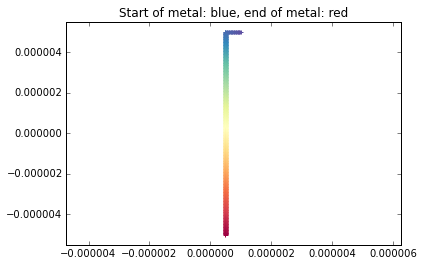

In [152]:
#To get the tangential velocity profile, have to calc the zeta potential along the contour.
#In Wu's paper, the induced zeta potential is Phi-sub-c - Phi-sub-e, where
#Phi-sub-c is the spatial average of the external voltage Phi-sub-e over the metal surface, 
#(Phi-sub-e is the external voltage I already have called 'voltage')
Phie=voltage #I'm going to call Phi-sub-e just "Phie"

#Now to calculate the surface area of the metal part only. perhaps I should have captured only the metal part
#But it is nice to have the rest, and later be able to calc surface velocity on the non metal part, 
#using the fixed zeta potential of whatever the un-metallized polymer membrane has.



plt.scatter(r[metalstart:metalend],z[metalstart:metalend],c=normdist[metalstart:metalend],marker='+')
plt.title('Start of metal: blue, end of metal: red')
ax=plt.gca()
lims=set_eq_axlims(r[metalstart:metalend],z[metalstart:metalend],.05)  #my function to repair this bug
ax.set_xlim(lims[0],lims[1])
ax.set_ylim(lims[2],lims[3])
#alriiight got the metal from 0 to metalend.
metalr=r[metalstart:metalend]
metaldist=Distance[metalstart:metalend]


metalarea=np.trapz(y=metalr,x=metaldist)  # *2pi) #approximate metal surface area by numerical integration in cylindrical coords
Phic=np.trapz(y=metalr*Phie[metalstart:metalend],x=metaldist)/metalarea #spatial average of Phie over metal surface
#Phic came out to about 23V in this example, I will check on that in another plot.
zeta=Phic-Phie #local induced zeta potential in volts. we should really keep it < 50 mV for validity
max(zeta),min(zeta)

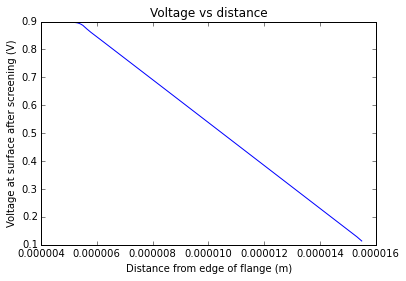

In [153]:
#plot voltage along the contour to check things
plt.plot(Distance[metalstart:metalend],voltage[metalstart:metalend])
plt.title('Voltage vs distance')
plt.xlabel('Distance from edge of flange (m)')
plt.ylabel('Voltage at surface after screening (V)')

In [158]:
#Keeping in mind the Helmholtz-Smoluchowski expression is hardly valid 
#for voltages > a few dozen mV, let's just check if it can export a usable surface profile.
ucontour=-epsilon*zeta*etang/eta  #Helmholtz-Smoluchowski slip velocity in meters/s along the direction of the contour
#for each point along the contour.

#meanwhile: what is the velocity range???
np.min(ucontour),np.max(ucontour)
#now break it down into components so we can export the velocity profile
#in ANSYS, x is the distance along the pore, which is called z here.
#And in ANSYS, y is the radial coordinate. Here, it has been called r.
#And in ANSYS there is no z-- we are doing a 2D axisymmetric simulation.
xAnsys=z[metalstart:metalend] #This calculates surf velocity just on the metal
yAnsys=r[metalstart:metalend]#Could add the AC velocity component from the bare polymer later
#zAnsys= 0, we don't need to export it
uvelocity=ucontour[metalstart:metalend]*tangz[metalstart:metalend]  #how do I do point by point mult with np arrays
vvelocity=ucontour[metalstart:metalend]*tangx[metalstart:metalend] #radial velocity small but nonzero at flange
#wvelocity=0 when I drew a contour in the Maxwell x-z plane, w won't be imported to 2D axisymm

1.6202184687207158e-06

In [155]:
outname='v'+str(vApp)+'_p'+str(poreDiaNanometers)+'_m'+str(membThickMicrons)+'_e'+str(elecSepMicrons)
outname=outname+'_s'+str(spacingNanometers)
outnameGeom='./ProfilesForAnsys/'+ outname+'_geom_'+outputSuffix
outnameProf='./ProfilesForAnsys/' + outname + '_prof_'+ outputSuffix
outnameGeom,outnameProf

('./ProfilesForAnsys/v1_p1000_m10_e20_s2000_geom_.txt',
 './ProfilesForAnsys/v1_p1000_m10_e20_s2000_prof_.txt')

In [156]:
#from these numbers, generate an output file for importing the same shape into 2D axisymm ANSYS CFD sim
zdom=float(elecSepMicrons)/2/1000000 #max |z| of sim domain in meters
zmemb=float(membThickMicrons)/2/1000000 #membrane max |z| in meters
rpore=float(poreDiaNanometers)/2/1000000000 #pore radius in meters
rdom=float(spacingNanometers)/2/1000000000 #sim domain radius in meters
f=open(outnameGeom,'w')
f.write ("1\t1\t%2.10f\t%2.10f\t0\r\n"%(-zdom,rdom))
f.write ("1\t2\t%2.10f\t%2.10f\t0\r\n"%(-zmemb,rdom))

f.write ("2\t1\t%2.10f\t%2.10f\t0\r\n"%(-zmemb,rdom))
f.write ("2\t2\t%2.10f\t%2.10f\t0\r\n"%(-zmemb,rpore))

f.write ("3\t1\t%2.10f\t%2.10f\t0\r\n"%(-zmemb,rpore))
f.write ("3\t2\t%2.10f\t%2.10f\t0\r\n"%(zmemb,rpore))

f.write ("4\t1\t%2.10f\t%2.10f\t0\r\n"%(zmemb,rpore))
f.write ("4\t2\t%2.10f\t%2.10f\t0\r\n"%(zmemb,rdom))

f.write ("5\t1\t%2.10f\t%2.10f\t0\r\n"%(zmemb,rdom))
f.write ("5\t2\t%2.10f\t%2.10f\t0\r\n"%(zdom,rdom))

f.write ("6\t1\t%2.10f\t%2.10f\t0\r\n"%(zdom,rdom))
f.write ("6\t2\t%2.10f\t%2.10f\t0\r\n"%(zdom,0))

f.write ("7\t1\t%2.10f\t%2.10f\t0\r\n"%(zdom,0))
f.write ("7\t2\t%2.10f\t%2.10f\t0\r\n"%(-zdom,0))

f.write ("8\t1\t%2.10f\t%2.10f\t0\r\n"%(-zdom,0))
f.write ("8\t2\t%2.10f\t%2.10f\t0\r\n"%(-zdom,rdom))

f.close()
#zdom,zmemb,rpore,rdom

In [157]:

f=open(outnameProf,'w')#Export the velocity profile in a format that ANSYS can use.
#Should I use all (several hundred) points or will it barf?? 
#Variables to write are xAnsys,yAnsys,uvelocity,vvelocity.
f.write("((" + outname + " point %5d)\r\n"%len(xAnsys))
f.write("(x")
for i in range(0,len(xAnsys)):
    f.write(" %e"%xAnsys[i])
f.write(")\r\n")
f.write("(y")
for i in range(0,len(xAnsys)):
    f.write(" %e"%yAnsys[i])
f.write(")\r\n")
f.write("(u")
for i in range(0,len(xAnsys)):
    f.write(" %e"%uvelocity[i])
f.write(")\r\n")
f.write("(v")
for i in range(0,len(xAnsys)):
    f.write(" %e"%vvelocity[i])
f.write("))\r\n")
f.close()